# Asset Integrity: Time-Series Anomaly Detection POC

This notebook detects anomalies in equipment sensor data for asset integrity management. It downloads CSV from a configurable URL or synthesizes realistic multi-sensor data with injected faults (spikes, drifts, stuck sensors). It performs EDA, engineers rolling/statistical features, runs STL-residual and IsolationForest detectors, and visualizes anomalies with simple explanations.

Run top-to-bottom. Configure `SENSOR_DATA_URL` env var to point to a CSV if available.


In [1]:
# Imports and setup
import os
import io
import math
import warnings
from dataclasses import dataclass
from typing import Optional, List

import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from sklearn.ensemble import IsolationForest

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-whitegrid")

SENSOR_DATA_URL = os.environ.get("SENSOR_DATA_URL", "")

@dataclass
class Cfg:
    time_col: str = "timestamp"
    id_col: str = "equipment_id"
    sensors: List[str] = None
    freq: str = "H"  # hourly data

CFG = Cfg(sensors=["pressure", "temperature", "vibration"])


In [2]:
# Data loading and synthesis with injected faults

def try_download(url: str, timeout: int = 30) -> Optional[pd.DataFrame]:
    if not url:
        return None
    try:
        r = requests.get(url, timeout=timeout)
        r.raise_for_status()
        return pd.read_csv(io.StringIO(r.text))
    except Exception as e:
        print(f"Download failed: {e}")
        return None


def synthesize(equipments=3, start="2024-01-01", periods=24*120, freq=CFG.freq, seed=7) -> pd.DataFrame:
    rng = np.random.default_rng(seed)
    ts = pd.date_range(start=start, periods=periods, freq=freq)
    rows = []
    for i in range(equipments):
        equip = f"EQ{i+1:02d}"
        base_p = rng.uniform(60, 120)
        base_t = rng.uniform(50, 90)
        base_v = rng.uniform(1.0, 3.0)
        drift_t = rng.uniform(-0.002, 0.003)
        for t_idx, t in enumerate(ts):
            # mild diurnal cycle
            cyc = 1 + 0.05 * math.sin(2*math.pi*(t_idx%24)/24.0)
            pressure = base_p * cyc + rng.normal(0, 0.8)
            temperature = base_t + drift_t*t_idx + 0.5*math.sin(2*math.pi*(t_idx%168)/168.0) + rng.normal(0, 0.5)
            vibration = base_v + 0.2*math.sin(2*math.pi*(t_idx%24)/24.0) + rng.normal(0, 0.1)
            rows.append({CFG.time_col: t, CFG.id_col: equip, "pressure": pressure, "temperature": temperature, "vibration": vibration})
        # inject anomalies
        inj_idx = rng.choice(len(ts), size=6, replace=False)
        for j in inj_idx:
            rows[j + i*len(ts)]["pressure"] += rng.uniform(10, 25)  # spikes
        # drift block
        start_d = rng.integers(24, len(ts)-72)
        for j in range(start_d, start_d+48):
            rows[j + i*len(ts)]["temperature"] += (j-start_d) * 0.15
        # stuck sensor
        stuck_start = rng.integers(24, len(ts)-48)
        stuck_val = rows[stuck_start + i*len(ts)]["vibration"]
        for j in range(stuck_start, stuck_start+36):
            rows[j + i*len(ts)]["vibration"] = stuck_val
    df = pd.DataFrame(rows)
    return df


def load_data() -> pd.DataFrame:
    df = try_download(SENSOR_DATA_URL)
    if df is None:
        print("Using synthetic sensor data with injected faults.")
        df = synthesize()
    # normalize
    rename = {c: c.strip().lower() for c in df.columns}
    df = df.rename(columns=rename)
    # coerce
    df[CFG.time_col] = pd.to_datetime(df[CFG.time_col])
    df = df.sort_values(CFG.time_col)
    for s in CFG.sensors:
        if s in df.columns:
            df[s] = pd.to_numeric(df[s], errors="coerce")
    if CFG.id_col in df.columns:
        df[CFG.id_col] = df[CFG.id_col].astype(str)
    df = df.dropna(subset=[CFG.time_col])
    return df

raw = load_data()
raw.head()


Using synthetic sensor data with injected faults.


,timestamp,equipment_id,pressure,temperature,vibration
0,2024-01-01 00:00:00,EQ01,97.141991,85.392729,2.557386
2880,2024-01-01 00:00:00,EQ02,82.176321,71.574407,2.240058
5760,2024-01-01 00:00:00,EQ03,106.547103,79.088443,0.916272
1,2024-01-01 01:00:00,EQ01,99.839717,85.660270,2.541088
2881,2024-01-01 01:00:00,EQ02,84.107296,71.794642,2.298786


               count unique   top  freq                           mean  \
timestamp       8640    NaN   NaN   NaN  2024-02-29 23:29:59.999999744   
equipment_id    8640      3  EQ01  2880                            NaN   
pressure      8640.0    NaN   NaN   NaN                      94.722491   
temperature   8640.0    NaN   NaN   NaN                      81.413338   
vibration     8640.0    NaN   NaN   NaN                       1.918286   

                              min                  25%                  50%  \
timestamp     2024-01-01 00:00:00  2024-01-30 23:45:00  2024-02-29 23:30:00   
equipment_id                  NaN                  NaN                  NaN   
pressure                75.567782            84.702421             97.57299   
temperature              69.81653            77.407442            83.334565   
vibration                0.545981             1.160158             2.177904   

                              75%                  max        std  
timestamp   

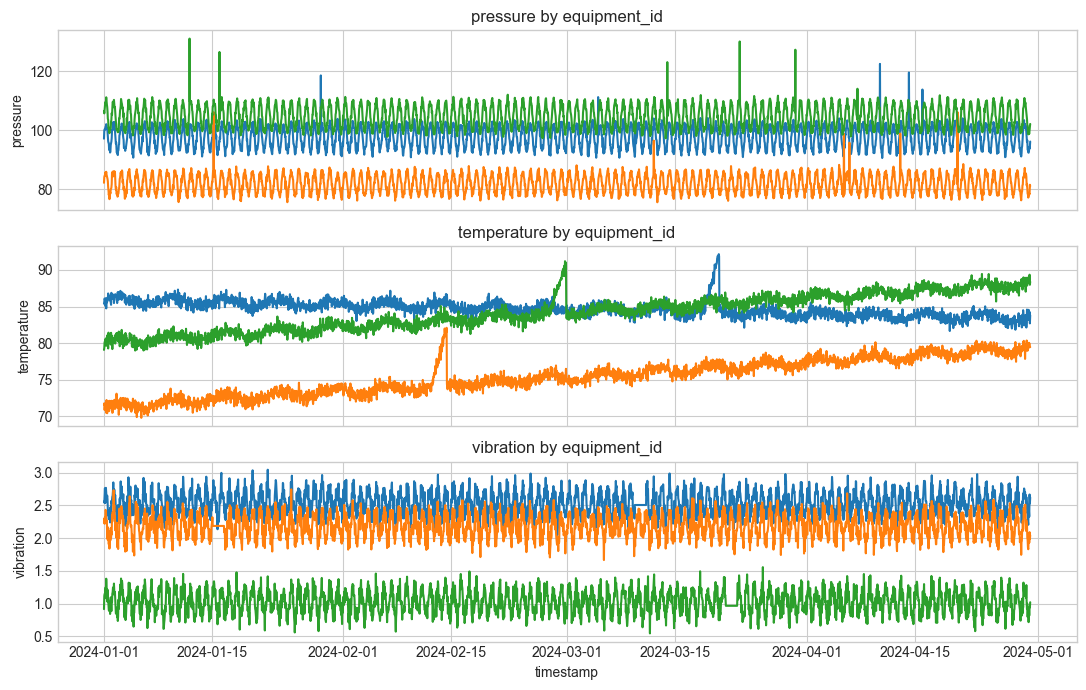

In [3]:
# EDA
print(raw.describe(include="all").T.head(12))

fig, axes = plt.subplots(len(CFG.sensors), 1, figsize=(11, 7), sharex=True)
for i, s in enumerate(CFG.sensors):
    if s in raw.columns:
        sns.lineplot(data=raw, x=CFG.time_col, y=s, hue=CFG.id_col, ax=axes[i], legend=False)
        axes[i].set_title(f"{s} by {CFG.id_col}")
plt.tight_layout()
plt.show()


In [4]:
# Feature engineering

def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df = df.set_index(CFG.time_col)
    parts = []
    for eq, g in df.groupby(CFG.id_col):
        g = g.asfreq(CFG.freq).interpolate(limit_direction="both")
        for s in CFG.sensors:
            if s in g.columns:
                g[f"{s}_diff1"] = g[s].diff(1)
                g[f"{s}_z"] = (g[s] - g[s].rolling(24, min_periods=6).mean()) / (g[s].rolling(24, min_periods=6).std() + 1e-6)
                g[f"{s}_ma12"] = g[s].rolling(12).mean()
                g[f"{s}_ma24"] = g[s].rolling(24).mean()
        g[CFG.id_col] = eq
        parts.append(g)
    out = pd.concat(parts).reset_index()
    return out

feat = add_features(raw)
feat.head()


,timestamp,equipment_id,pressure,temperature,vibration,pressure_diff1,pressure_z,pressure_ma12,pressure_ma24,temperature_diff1,temperature_z,temperature_ma12,temperature_ma24,vibration_diff1,vibration_z,vibration_ma12,vibration_ma24
0,2024-01-01 00:00:00,EQ01,97.141991,85.392729,2.557386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-01-01 01:00:00,EQ01,99.839717,85.660270,2.541088,2.697726,NaN,NaN,NaN,0.267542,NaN,NaN,NaN,-0.016298,NaN,NaN,NaN
2,2024-01-01 02:00:00,EQ01,100.335245,86.102613,2.661913,0.495528,NaN,NaN,NaN,0.442342,NaN,NaN,NaN,0.120825,NaN,NaN,NaN
3,2024-01-01 03:00:00,EQ01,100.208702,85.927286,2.762323,-0.126543,NaN,NaN,NaN,-0.175326,NaN,NaN,NaN,0.100410,NaN,NaN,NaN
4,2024-01-01 04:00:00,EQ01,100.652478,85.730769,2.534454,0.443777,NaN,NaN,NaN,-0.196517,NaN,NaN,NaN,-0.227869,NaN,NaN,NaN


In [5]:
# STL residual-based anomaly scores

def stl_residual_scores(g: pd.DataFrame, column: str) -> pd.Series:
    x = g[column].asfreq(CFG.freq).interpolate(limit_direction="both")
    if x.isna().all():
        return pd.Series(index=g.index, dtype=float)
    try:
        stl = STL(x, period=24)
        res = stl.fit()
        resid = res.resid
        z = (resid - resid.rolling(48, min_periods=12).mean()) / (resid.rolling(48, min_periods=12).std() + 1e-6)
        return z.reindex(g.index)
    except Exception:
        return pd.Series(index=g.index, dtype=float)

scores = []
for eq, g in feat.set_index(CFG.time_col).groupby(CFG.id_col):
    g = g.sort_index()
    sc = pd.DataFrame(index=g.index)
    for s in [c for c in CFG.sensors if c in g.columns]:
        sc[f"{s}_stl_z"] = stl_residual_scores(g, s)
    sc[CFG.id_col] = eq
    scores.append(sc)
score_df = pd.concat(scores).reset_index()
score_df.head()


,timestamp,pressure_stl_z,temperature_stl_z,vibration_stl_z,equipment_id
0,2024-01-01 00:00:00,NaN,NaN,NaN,EQ01
1,2024-01-01 01:00:00,NaN,NaN,NaN,EQ01
2,2024-01-01 02:00:00,NaN,NaN,NaN,EQ01
3,2024-01-01 03:00:00,NaN,NaN,NaN,EQ01
4,2024-01-01 04:00:00,NaN,NaN,NaN,EQ01


In [7]:
# IsolationForest multivariate detector
from sklearn.preprocessing import StandardScaler

features = []
for s in CFG.sensors:
    features += [f"{s}", f"{s}_diff1", f"{s}_z", f"{s}_ma12", f"{s}_ma24"]

merged = pd.merge(feat, score_df, left_on=[CFG.time_col, CFG.id_col], right_on=[CFG.time_col, CFG.id_col], how="left")

anom = []
for eq, g in merged.groupby(CFG.id_col):
    X = g[features].copy()
    X = X.replace([np.inf, -np.inf], np.nan).fillna(method="ffill").fillna(method="bfill").fillna(0)
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    iso = IsolationForest(n_estimators=200, contamination=0.02, random_state=42)
    iso.fit(Xs)
    scores = -iso.decision_function(Xs)  # higher = more anomalous
    preds = iso.predict(Xs)  # -1 anomalous, 1 normal
    gg = g[[CFG.time_col, CFG.id_col]].copy()
    gg["if_score"] = scores
    gg["if_pred"] = preds
    gg["anomaly"] = (preds == -1) | (g[[c for c in g.columns if c.endswith("_stl_z")]].abs().max(axis=1) > 3)
    anom.append(gg)

anom_df = pd.concat(anom, ignore_index=True)

# Join back for plotting
final = pd.merge(merged, anom_df, on=[CFG.time_col, CFG.id_col], how="left")
final.head()


,timestamp,equipment_id,pressure,temperature,vibration,pressure_diff1,pressure_z,pressure_ma12,pressure_ma24,temperature_diff1,...,vibration_diff1,vibration_z,vibration_ma12,vibration_ma24,pressure_stl_z,temperature_stl_z,vibration_stl_z,if_score,if_pred,anomaly
0,2024-01-01 00:00:00,EQ01,97.141991,85.392729,2.557386,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.043106,1,False
1,2024-01-01 01:00:00,EQ01,99.839717,85.660270,2.541088,2.697726,NaN,NaN,NaN,0.267542,...,-0.016298,NaN,NaN,NaN,NaN,NaN,NaN,-0.047135,1,False
2,2024-01-01 02:00:00,EQ01,100.335245,86.102613,2.661913,0.495528,NaN,NaN,NaN,0.442342,...,0.120825,NaN,NaN,NaN,NaN,NaN,NaN,-0.050999,1,False
3,2024-01-01 03:00:00,EQ01,100.208702,85.927286,2.762323,-0.126543,NaN,NaN,NaN,-0.175326,...,0.100410,NaN,NaN,NaN,NaN,NaN,NaN,-0.050852,1,False
4,2024-01-01 04:00:00,EQ01,100.652478,85.730769,2.534454,0.443777,NaN,NaN,NaN,-0.196517,...,-0.227869,NaN,NaN,NaN,NaN,NaN,NaN,-0.050619,1,False


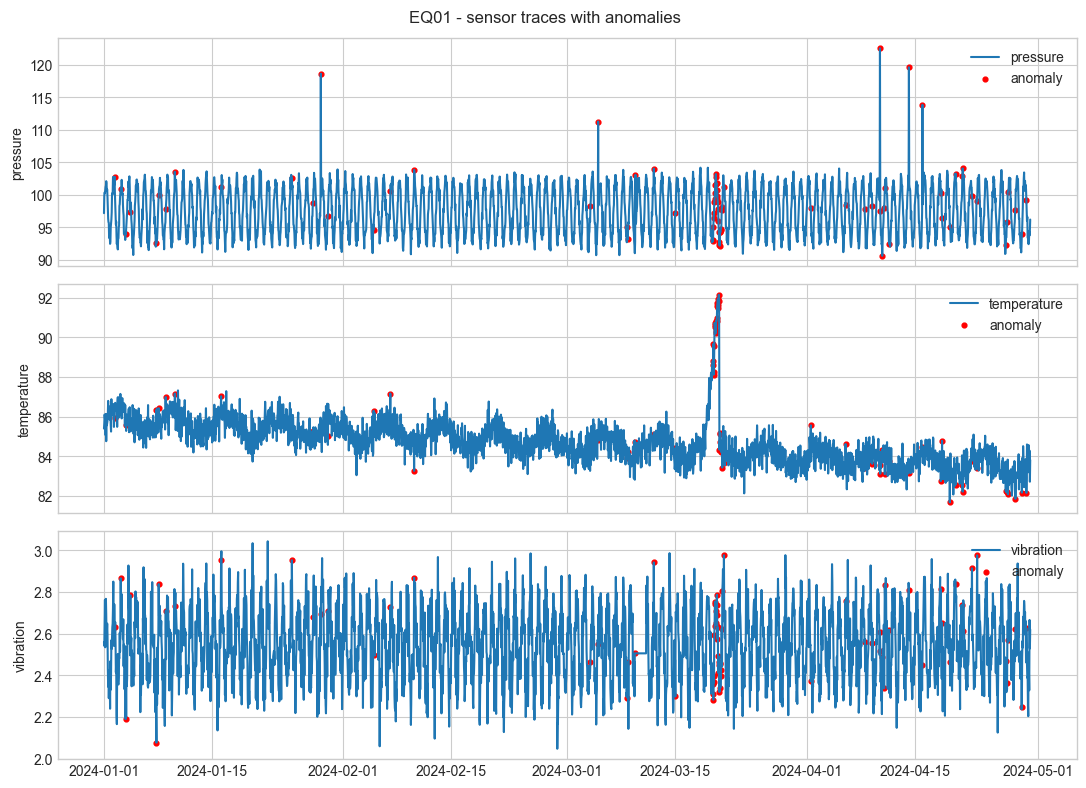

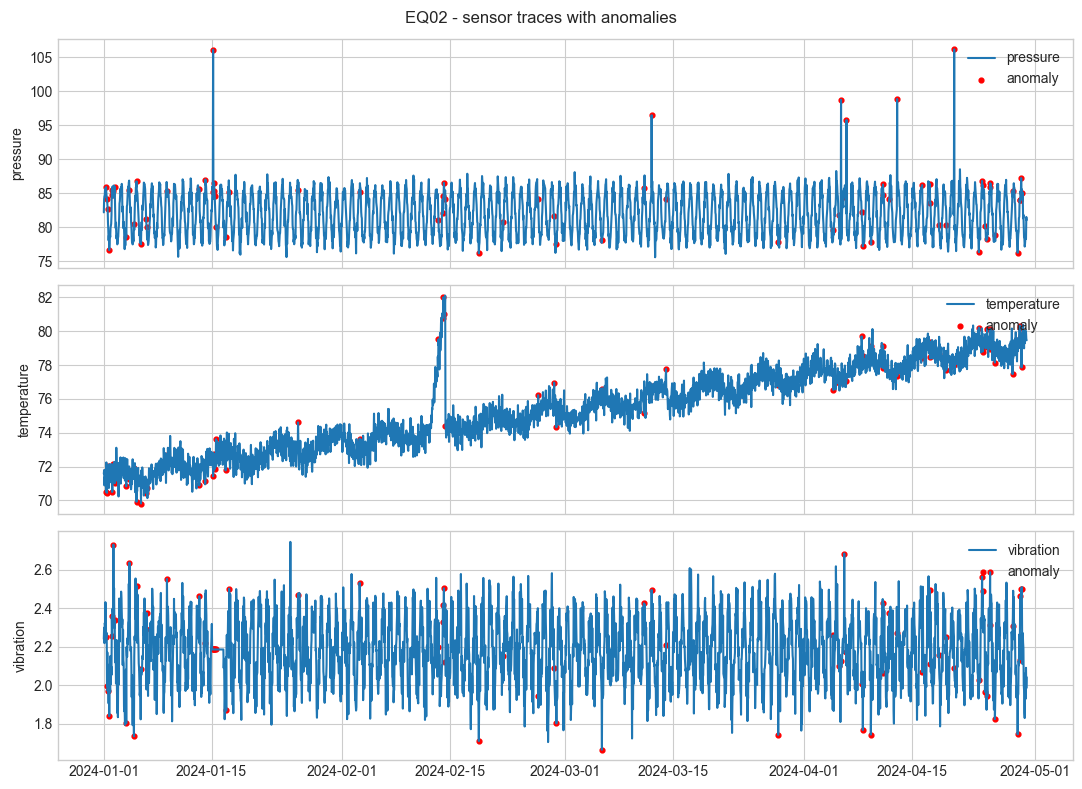

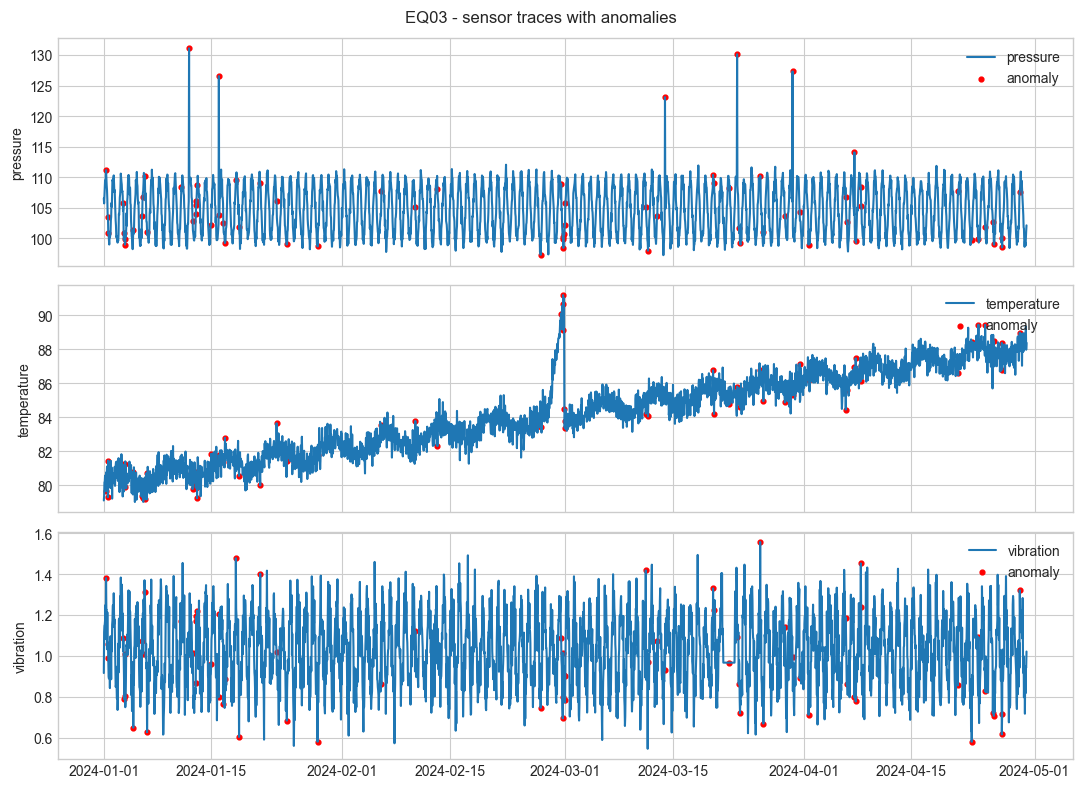

,anomaly_count,anomaly_rate
equipment_id,,
EQ01,79,0.027431
EQ02,75,0.026042
EQ03,72,0.025000


In [8]:
# Visualization of anomalies
for eq, g in final.groupby(CFG.id_col):
    fig, axes = plt.subplots(len(CFG.sensors), 1, figsize=(11, 8), sharex=True)
    fig.suptitle(f"{eq} - sensor traces with anomalies")
    for i, s in enumerate(CFG.sensors):
        if s in g.columns:
            axes[i].plot(g[CFG.time_col], g[s], label=s)
            # highlight anomalies
            mask = g["anomaly"] == True
            axes[i].scatter(g.loc[mask, CFG.time_col], g.loc[mask, s], color="red", s=12, label="anomaly")
            axes[i].set_ylabel(s)
            axes[i].legend(loc="upper right")
    plt.tight_layout()
    plt.show()

# Summary table
summary = (final.groupby(CFG.id_col)["anomaly"].agg(["sum","mean"]).rename(columns={"sum":"anomaly_count","mean":"anomaly_rate"}))
summary
